# NIRCam F356W Coronagraphic Observations of Vega 
---
Here we create the basics for a MIRI simulation to observe the Fomalhaut system with the FQPM 1550. This includes simulating the Fomalhaut stellar source behind the center of the phase mask, some fake off-axis companions, and a debris disk model that crosses the mask's quadrant boundaries.

From JWST PID 1193, the pointing file provides some the relevant information. Here's a truncated version of the pointing file for the first roll position. In this example, we skip the target acquisition observations and only simulate the science exposure image.
```
* Fomalhaut-1550C-Rot1 (Obs 6)
** Visit 6:1
Aperture Name     Target        RA        Dec         V2       V3      IdlX    IdlY   Level    Type 
MIRIM_TABLOCK     1 VEGA      +279.23474 +38.78369  -407.464 -387.100  +0.000  +0.000 TARGET   T_ACQ 
MIRIM_TA1550_UR   1 VEGA      +279.23474 +38.78369  -395.471 -365.842  +0.000  +0.000 TARGET   T_ACQ 
MIRIM_TA1550_CUR  1 VEGA      +279.23474 +38.78369  -391.430 -370.519  +0.122  +0.134 TARGET   T_ACQ 
MIRIM_MASK1550    1 VEGA      +279.23474 +38.78369  -389.892 -372.181  +0.000  +0.000 TARGET   SCIENCE 
```

Final outputs will be detector-sampled slope images (counts/sec).

In [1]:
# Import the usual libraries
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
#import matplotlib.patches as mpatches

# Enable inline plotting
%matplotlib inline

# Progress bar
from tqdm.auto import trange, tqdm

In [2]:
import webbpsf_ext, pysiaf
from astropy.io import fits

In [3]:
from webbpsf_ext import image_manip, setup_logging, spectra, coords

# NIRCam Observation with MASK430R+F356W

## 1. Create PSF structure

In [4]:
# Mask information
filt = 'F356W'
mask = 'MASK430R'
pupil = 'CIRCLYOT'

# Initiate instrument class with selected filters, pupil mask, and image mask
inst = webbpsf_ext.NIRCam_ext(filter=filt, pupil_mask=pupil, image_mask=mask)

[   webbpsf:INFO] NIRCam aperture name updated to NRCA1_FULL
[   webbpsf:INFO] NIRCam pixel scale switched to 0.063000 arcsec/pixel for the long wave channel.
[   webbpsf:INFO] NIRCam aperture name updated to NRCA5_FULL
[   webbpsf:INFO] NIRCam aperture name updated to NRCA5_FULL_WEDGE_RND
[   webbpsf:INFO] NIRCam aperture name updated to NRCA5_FULL_MASK430R


In [5]:
# Set desired PSF size and oversampling
inst.fov_pix = 256
inst.oversample = 2

In [6]:
# Calculate PSF coefficients
inst.gen_psf_coeff()

[webbpsf_ext:INFO] Loading /Users/Jarron/NIRCam/webbpsf_ext_data/psf_coeffs/NIRCam/LWA_F356W_CIRCLYOT_MASK430R_pix256_os2_jsig0_r0.00_th+0.0_RevWslice0_siwfe_distort_legendre.fits


In [7]:
# Calculate position-dependent PSFs due to FQPM
# Equivalent to generating a giant library to interpolate over
inst.gen_wfemask_coeff()

[webbpsf_ext:INFO] Loading /Users/Jarron/NIRCam/webbpsf_ext_data/psf_coeffs/NIRCam/LWA_F356W_CIRCLYOT_MASK430R_pix256_os2_jsig0_r0.00_th+0.0_RevWslice0_siwfe_distort_legendre_wfemask.npz


## 1.1 Observation setup

__Configuring observation settings__

Observations consist of nested visit, mosaic tiles, exposures, and dithers. In this section, we configure a pointing class that houses information for a single observation defined in the APT .pointing file. The primary information includes a pointing reference SIAF aperturne name, RA and Dec of the ref aperture, Base X/Y offset relative to the ref aperture position, and Dith X/Y offsets. From this information, along with the V2/V3 position angle, we can determine the orientation and location of objects on the detector focal plane.

**Note**: The reference aperture is not necessarily the same as the observed aperture. For instance, you may observe simultaneously with four of NIRCam's SWA detectors, so the reference aperture would be the entire SWA channel, while the observed apertures are A1, A2, A3, and A4.

In [8]:
# Import class to setup pointing info
from webbpsf_ext.coords import jwst_point

In [9]:
# Observed and reference apertures
ap_obs = 'NRCA5_MASK430R'
ap_ref = 'NRCA5_MASK430R'
    
# Define the RA/Dec of reference aperture and telescope position angle
# Position angle is angle of V3 axis rotated towards East
ra_ref, dec_ref = (+279.23474,  +38.78369)
pos_ang = 30

# Set any baseline pointing offsets (e.g., specified in APT's Special Requirements)
base_offset=(0,0)
# Define a list of nominal dither offsets
dith_offsets = [(0,0)]

# Telescope pointing information
tel_point = jwst_point(ap_obs, ap_ref, ra_ref, dec_ref, pos_ang=pos_ang,
                       base_offset=base_offset, dith_offsets=dith_offsets)

[webbpsf_ext:INFO] Generating random pointing offsets...
[webbpsf_ext:INFO] Pointing uncertainty: 5.0 mas
[webbpsf_ext:INFO]   Pos 0 dither uncertainty: 0.0 mas


In [10]:
print(f"Reference aperture: {tel_point.siaf_ap_ref.AperName}")
print(f"  Nominal RA, Dec = ({tel_point.ra_ref:.6f}, {tel_point.dec_ref:.6f})")
print(f"Observed aperture: {tel_point.siaf_ap_obs.AperName}")
print(f"  Nominal RA, Dec = ({tel_point.ra_obs:.6f}, {tel_point.dec_obs:.6f})")

print(f"Relative offsets in 'idl' for each dither position (incl. pointing errors)")
for i, offset in enumerate(tel_point.position_offsets_act):
    print(f"  Position {i}: ({offset[0]:.4f}, {offset[1]:.4f}) arcsec")

Reference aperture: NRCA5_MASK430R
  Nominal RA, Dec = (279.234740, 38.783690)
Observed aperture: NRCA5_MASK430R
  Nominal RA, Dec = (279.234740, 38.783690)
Relative offsets in 'idl' for each dither position (incl. pointing errors)
  Position 0: (0.0041, 0.0049) arcsec


## 1.2 Add central source

Here we define the stellar atmosphere parameters for Fomalhaut, including spectral type, optional values for (Teff, log_g, metallicity), normalization flux and bandpass, as well as RA and Dec.

In [11]:
from webbpsf_ext import miri_filter, nircam_filter, bp_2mass
from webbpsf_ext.image_manip import pad_or_cut_to_size

def make_spec(name=None, sptype=None, flux=None, flux_units=None, bp_ref=None, **kwargs):
    """
    Create pysynphot stellar spectrum from input dictionary properties.
    """

    from webbpsf_ext import stellar_spectrum
    
    # Renormalization arguments
    renorm_args = (flux, flux_units, bp_ref)
    
    # Create spectrum
    sp = stellar_spectrum(sptype, *renorm_args, **kwargs)
    if name is not None:
        sp.name = name
    
    return sp

In [12]:
# Information necessary to create pysynphot spectrum of star
obj_params = {
    'name': 'Vega', 
    'sptype': 'A0V', 
    'Teff': 9602, 'log_g': 4.1, 'metallicity': -0.5, 
    'dist': 7.7,
    'flux': 16.09, 'flux_units': 'Jy', 'bp_ref': miri_filter('F1550C'),
    'RA_obj'  : +279.23474,  # RA (decimal deg) of source
    'Dec_obj' :  +38.78369,  # Dec (decimal deg) of source
}

In [13]:
# Create stellar spectrum and add to dictionary
sp_star = make_spec(**obj_params)
obj_params['sp'] = sp_star

In [14]:
# Get `sci` coord positions
coord_obj = (obj_params['RA_obj'], obj_params['Dec_obj'])
xsci, ysci = tel_point.radec_to_frame(coord_obj, frame_out='sci')

# Get sci position shifts from center in units of detector pixels
siaf_ap = tel_point.siaf_ap_obs
xsci_cen, ysci_cen = siaf_ap.reference_point('sci')
xsci_off, ysci_off = (xsci-xsci_cen, ysci-ysci_cen)

# and now oversampled pixel shifts
osamp = inst.oversample
xsci_off_over = xsci_off * osamp
ysci_off_over = ysci_off * osamp

print("Image shifts (oversampled pixels):", xsci_off_over, ysci_off_over)

Image shifts (oversampled pixels): 0.13178942571130392 0.155352791577684


In [15]:
tel_point.radec_to_frame(coord_obj, frame_out='sci')

(160.56453736556387, 172.57634341315435)

In [16]:
# Create PSF
# PSFs already includes geometric distortions based on SIAF info
sp = obj_params['sp']
xtel, ytel = siaf_ap.convert(xsci, ysci, 'sci', 'tel')
hdul = inst.calc_psf_from_coeff(sp=sp, coord_vals=(xtel,ytel), coord_frame='tel')

# Expand PSF to full frame and offset to proper position
ny_pix, nx_pix = (siaf_ap.YSciSize, siaf_ap.XSciSize)
ny_pix_over, nx_pix_over = np.array([ny_pix, nx_pix]) * osamp
shape_new = (ny_pix*osamp, nx_pix*osamp)
delyx = (ysci_off_over, xsci_off_over)
image_full = pad_or_cut_to_size(hdul[0].data, shape_new, offset_vals=delyx)

# Make new HDUList of target (just central source so far)
hdul_full = fits.HDUList(fits.PrimaryHDU(data=image_full, header=hdul[0].header))

[webbpsf_ext:INFO] Generating mask-dependent modifications...


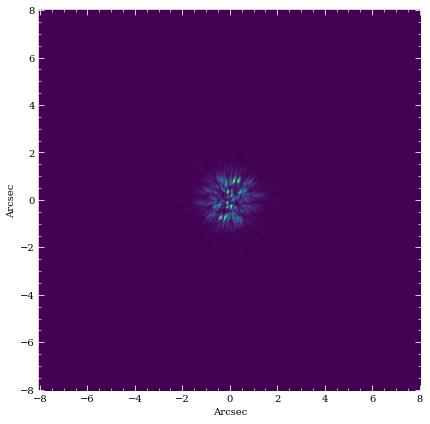

In [17]:
fig, ax = plt.subplots(1,1)

extent = 0.5 * np.array([-1,1,-1,1]) * inst.fov_pix * inst.pixelscale
ax.imshow(hdul_full[0].data, extent=extent)

ax.set_xlabel('Arcsec')
ax.set_ylabel('Arcsec')

ax.tick_params(axis='both', color='white', which='both')
for k in ax.spines.keys():
    ax.spines[k].set_color('white')
ax.xaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])
ax.yaxis.get_major_locator().set_params(nbins=9, steps=[1, 2, 5, 10])

fig.tight_layout()

## 1.3 Convolve extended disk image

Properly including extended objects is a little more complicated than for point sources. First, we need properly format the input model to a pixel binning and flux units appropriate for the simulations (ie., pixels should be equal to oversampled PSFs with flux units of counts/sec). Then, the image needs to be rotated relative to the 'idl' coordinate plane and subsequently shifted for any pointing offsets. Once in the appropriate 'idl' system 


### 1.3.1 PSF Grid

In [19]:
# Create grid locations for array of PSFs to generate
field_rot = 0 if inst._rotation is None else inst._rotation

rvals = 10**(np.linspace(-2,1,7))
thvals = np.linspace(0, 360, 9, endpoint=False)

rvals_all = [0]
thvals_all = [0]
for r in rvals:
    for th in thvals:
        rvals_all.append(r)
        thvals_all.append(th)
rvals_all = np.array(rvals_all)
thvals_all = np.array(thvals_all)

xgrid_off, ygrid_off = coords.rtheta_to_xy(rvals_all, thvals_all)

# xyoff_half = 10**(np.linspace(-2,1,5))
# xoff = yoff = np.concatenate([-1*xyoff_half[::-1],[0],xyoff_half])

# # Mask Offset grid positions in arcsec
# xgrid_off, ygrid_off = np.meshgrid(xoff, yoff)
# xgrid_off, ygrid_off = xgrid_off.flatten(), ygrid_off.flatten()

# Science positions in detector pixels
xoff_sci_asec, yoff_sci_asec = coords.xy_rot(-1*xgrid_off, -1*ygrid_off, -1*field_rot)
xsci = xoff_sci_asec / siaf_ap.XSciScale + siaf_ap.XSciRef
ysci = yoff_sci_asec / siaf_ap.YSciScale + siaf_ap.YSciRef

xtel, ytel = siaf_ap.convert(xsci, ysci, 'sci', 'tel')

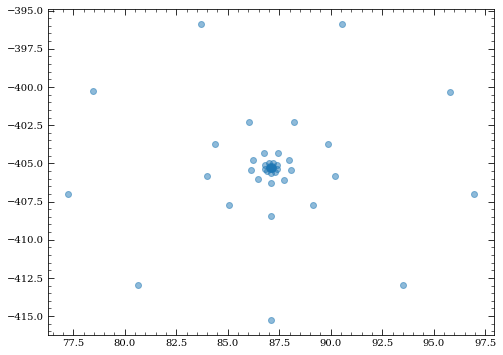

In [20]:
plt.plot(xtel, ytel, marker='o', ls='none', alpha=0.5)

In [21]:
%%time

# Now, create all PSFs, one for each (xsci, ysci) location
# Only need to do this once. Can be used for multiple dither positions.
hdul_psfs = inst.calc_psf_from_coeff(coord_vals=(xtel, ytel), coord_framae='tel', return_oversample=True)

[webbpsf_ext:INFO] Generating mask-dependent modifications...


PSFs:   0%|          | 0/64 [00:00<?, ?it/s]

CPU times: user 1min 31s, sys: 46.8 s, total: 2min 18s
Wall time: 50.5 s


### 1.3.2 Disk Model Image

In [22]:
# Disk model information
disk_params = {
    'file': "Vega/Vega_F335Msccomb.fits",
    'pixscale': inst.pixelscale,
    'wavelength': 3.35,
    'units': 'Jy/pixel',
    'dist' : 7.7,
    'cen_star' : False,
}

# Open model and rebin to PSF sampling
# Scale to instrument wavelength assuming grey scattering function
# Converts to phot/sec/lambda
# Crop to twice the FoV
npix = int(2*siaf_ap.YSciSize*inst.oversample)
hdul_disk_model = image_manip.make_disk_image(inst, disk_params, sp_star=obj_params['sp'], shape_out=npix)

# Rotation necessary to go from sky coordinates to 'idl' frame
rotate_to_idl = -1*(tel_point.siaf_ap_obs.V3IdlYAngle + tel_point.pos_ang)

### 1.3.3 Dither Position

In [23]:
# Select the first dither location offset
delx, dely = tel_point.position_offsets_act[0]
hdul_out = image_manip.rotate_shift_image(hdul_disk_model, PA_offset=rotate_to_idl,
                                          delx_asec=delx, dely_asec=dely)

sci_cen = (siaf_ap.XSciRef, siaf_ap.YSciRef)

# Distort image on 'sci' coordinate grid
im_sci, xsci_im, ysci_im = image_manip.distort_image(hdul_out, ext=0, to_frame='sci', return_coords=True, 
                                                     aper=siaf_ap, sci_cen=sci_cen)

# Distort image onto 'tel' (V2, V3) coordinate grid for plot illustration
im_tel, v2_im, v3_im = image_manip.distort_image(hdul_out, ext=0, to_frame='tel', return_coords=True, 
                                                 aper=siaf_ap, sci_cen=sci_cen)

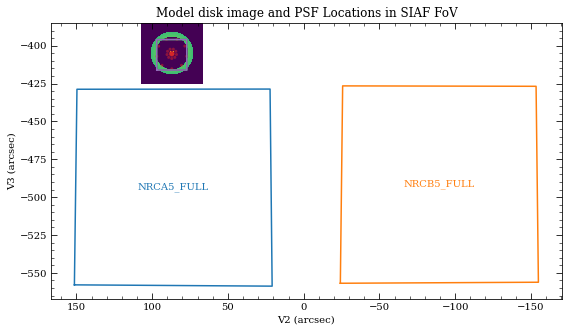

In [24]:
# Plot locations for PSFs that we will generate
fig, ax = plt.subplots(1,1)

# Show image in V2/V3 plane
extent = [v2_im.min(), v2_im.max(), v3_im.min(), v3_im.max()]
ax.imshow(im_tel**0.1, extent=extent)

# Add on SIAF aperture boundaries
tel_point.plot_inst_apertures(ax=ax, clear=False, label=True)
tel_point.plot_ref_aperture(ax=ax)
tel_point.plot_obs_aperture(ax=ax, color='C4')

# Add PSF location points
v2, v3 = siaf_ap.convert(xsci, ysci, 'sci', 'tel')
ax.scatter(v2, v3, marker='.', alpha=0.5, color='C3', edgecolors='none', linewidths=0)

ax.set_title('Model disk image and PSF Locations in SIAF FoV')

fig.tight_layout()

This particular disk image is oversized, so we will need to crop the image after convolving PSFs. We may want to consider trimming some of this image prior to convolution, depending on how some of the FoV is blocked before reaching the coronagraphic optics.

In [25]:
# If the image is too large, then this process will eat up much of your computer's RAM
# So, crop image to more reasonable size (20% oversized)
osamp = inst.oversample
xysize = int(1.2 * np.max([siaf_ap.XSciSize,siaf_ap.YSciSize]) * osamp)
xy_add = osamp - np.mod(xysize, osamp)
xysize += xy_add

im_sci_crop = pad_or_cut_to_size(im_sci, xysize)

# Multiply times ND mask
if inst.name=='NIRCam':
    im_mask = inst.gen_mask_image(npix=xysize)
    rarr, tharr = coords.dist_image(im_mask, pixscale=inst.pixelscale, return_theta=True)
    xarr, yarr = coords.rtheta_to_xy(rarr, tharr)
    ind_clear = np.abs(yarr)<4
    im_mask[ind_clear] = 1
    im_sci_crop = im_sci_crop * im_mask

hdul_disk_model_sci = fits.HDUList(fits.PrimaryHDU(data=im_sci_crop, header=hdul_out[0].header))

In [26]:
# Convolve image
im_conv = image_manip.convolve_image(hdul_disk_model_sci, hdul_psfs, aper=siaf_ap)

  0%|          | 0/64 [00:00<?, ?it/s]

Closing multiprocess pool.


In [27]:
# Add cropped image to final oversampled image
im_conv = pad_or_cut_to_size(im_conv, hdul_full[0].data.shape)

im_psf = hdul_full[0].data.copy()
hdul_full[0].data += im_conv

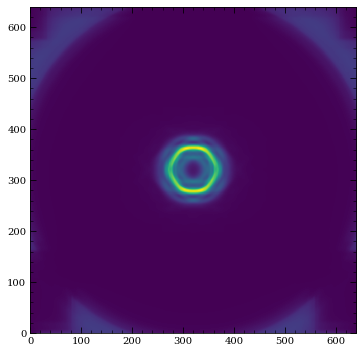

In [28]:
plt.imshow(im_conv)

In [29]:
# Subtract a reference PSF from the science data
# Assume perfect subtraction
im_ref = image_manip.frebin(im_psf, scale=1/osamp)

# Rebin science data to detector pixels
im_sci = image_manip.frebin(hdul_full[0].data, scale=1/osamp)
imdiff = im_sci - im_ref

# De-rotate to sky orientation
imrot = image_manip.rotate_offset(imdiff, rotate_to_idl, reshape=False, cval=np.nan)

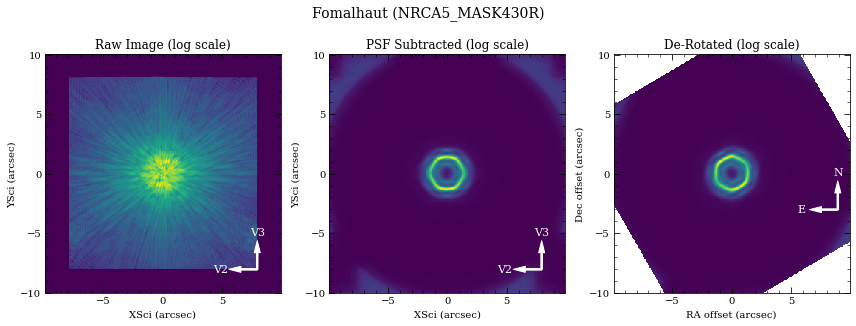

In [30]:
from matplotlib.colors import LogNorm
from webbpsf_ext.coords import plotAxes

fig, axes = plt.subplots(1,3, figsize=(12,4.5))

############################
# Plot raw image
ax = axes[0]

im = im_sci
mn = np.median(im)
std = np.std(im)
vmin = 0
vmax = mn+10*std

xsize_asec = siaf_ap.XSciSize * siaf_ap.XSciScale
ysize_asec = siaf_ap.YSciSize * siaf_ap.YSciScale
extent = [-1*xsize_asec/2, xsize_asec/2, -1*ysize_asec/2, ysize_asec/2]
norm = LogNorm(vmin=im.max()/1e5, vmax=im.max())
ax.imshow(im, extent=extent, norm=norm)

ax.set_title("Raw Image (log scale)")

ax.set_xlabel('XSci (arcsec)')
ax.set_ylabel('YSci (arcsec)')
plotAxes(ax, angle=-1*siaf_ap.V3SciYAngle)

############################
# Basic PSF subtraction
# Subtract a near-perfect reference PSF
ax = axes[1]
norm = LogNorm(vmin=imdiff.max()/1e5, vmax=imdiff.max())
ax.imshow(imdiff, extent=extent)

ax.set_title("PSF Subtracted (log scale)")

ax.set_xlabel('XSci (arcsec)')
ax.set_ylabel('YSci (arcsec)')
plotAxes(ax, angle=-1*siaf_ap.V3SciYAngle)

############################
# De-rotate to sky orientation

ax = axes[2]
ax.imshow(imrot, extent=extent)

ax.set_title("De-Rotated (log scale)")

ax.set_xlabel('RA offset (arcsec)')
ax.set_ylabel('Dec offset (arcsec)')
plotAxes(ax, position=(0.95,0.35), label1='E', label2='N')

for i, ax in enumerate(axes.flatten()):
    ax.xaxis.get_major_locator().set_params(nbins=7, steps=[1, 2, 5, 10])
    ax.yaxis.get_major_locator().set_params(nbins=7, steps=[1, 2, 5, 10])

fig.suptitle(f"Fomalhaut ({siaf_ap.AperName})", fontsize=14)
fig.tight_layout()

In [36]:
# Save image to FITS file
hdu_diff = fits.PrimaryHDU(imdiff)

copy_keys = [
    'PIXELSCL', 'DISTANCE', 
    'INSTRUME', 'FILTER', 'PUPIL', 'CORONMSK',
    'APERNAME', 'MODULE', 'CHANNEL',
    'DET_NAME', 'DET_X', 'DET_Y', 'DET_V2', 'DET_V3'
]

hdr = hdu_diff.header
for head_temp in (inst.psf_coeff_header, hdul_out[0].header):
    for key in copy_keys:
        try:
            hdr[key] = (head_temp[key], head_temp.comments[key])
        except (AttributeError, KeyError):
            pass

hdr['PIXELSCL'] = inst.pixelscale

In [37]:
name = obj_params['name']

outfile = f'Vega/{name}_{inst.aperturename}_{inst.filter}.fits'
hdu_diff.writeto(outfile, overwrite=True)

In [34]:
outfile

'Vega/Vega_NRCA5_FULL_MASK430R_F356W.fits'

In [52]:
im_conv.max()

0.13907668595263234